# HCV — Classification clinique (Enhanced) : Génotype 1 vs Génotype 2  
**Notebook Google Colab (académique + anti-leakage)**

Ce notebook est une version **renforcée** pour éviter les performances artificiellement parfaites (1.0 partout), souvent causées par :
- **doublons** / séquences identiques dans le dataset,
- **quasi-doublons** (séquences très proches),
- fuite d’information via **la longueur** (une classe plus longue que l’autre),
- séparation trop facile liée à la collecte (mêmes isolats / mêmes lots).

Solutions intégrées :
1. **Nettoyage contrôlé** + filtrage
2. **Découpage à longueur fixe** (supprime le biais “longueur”)
3. **Déduplication stricte** + suppression de chevauchements inter-classes
4. (Option) **Filtrage de quasi-doublons** via similarité k-mers (cosine)
5. Validation croisée robuste : **StratifiedKFold** + ROC/AUC
6. **Test de sanité** : labels shuffled → AUC ≈ 0.5 attendu
7. Export & téléchargement des artefacts

---

## Données
Uploadez :
- `hcv_g1.fasta`
- `hcv_g2.fasta`

> Si vous obtenez encore 1.0 partout après ces contrôles, votre jeu est probablement **trop redondant** ou mal étiqueté.

In [1]:
# =========================
# 0) Setup
# =========================
!pip -q install biopython joblib

import os, re, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from Bio import SeqIO

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.pairwise import cosine_similarity

import joblib

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

def md5(s: str) -> str:
    return hashlib.md5(s.encode()).hexdigest()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.1 MB/s eta 0:00:00


## 1) Upload (Colab)
Le notebook détecte automatiquement des noms contenant `g1` et `g2` (ou `gt1/gt2`).

In [2]:
# =========================
# 1) Upload
# =========================
uploaded = files.upload()
keys = list(uploaded.keys())
low = [k.lower() for k in keys]

g1_candidates = [keys[i] for i,k in enumerate(low) if ("g1" in k) or ("genotype1" in k) or ("gt1" in k)]
g2_candidates = [keys[i] for i,k in enumerate(low) if ("g2" in k) or ("genotype2" in k) or ("gt2" in k)]

if not g1_candidates or not g2_candidates:
    raise FileNotFoundError(
        "Détection automatique échouée. Renommez vos fichiers avec 'g1' et 'g2' "
        "(ex: hcv_g1.fasta, hcv_g2.fasta) et ré-uploadez."
    )

G1_PATH = g1_candidates[0]
G2_PATH = g2_candidates[0]

print("Fichiers détectés :")
print(" - G1:", G1_PATH)
print(" - G2:", G2_PATH)

Saving hcv_g1.fasta to hcv_g1.fasta
Saving hcv_g2.fasta to hcv_g2.fasta
Fichiers détectés :
 - G1: hcv_g1.fasta
 - G2: hcv_g2.fasta


## 2) Nettoyage + extraction + longueur fixe (anti-biais)

### Pourquoi longueur fixe ?
Si une classe a des séquences plus longues/plus complètes, un modèle peut “tricher” en apprenant la longueur.

**Stratégie** :
- nettoyer (A/C/G/T uniquement),
- garder uniquement les séquences ≥ `WINDOW_LEN`,
- extraire un **segment de longueur fixe** (`WINDOW_LEN`) :  
  - par défaut : segment aléatoire reproductible (seed), ce qui augmente la robustesse.

Paramètres recommandés HCV :
- `WINDOW_LEN = 9000` (génome HCV ≈ 9600 nt)

In [3]:
# =========================
# 2) FASTA -> (seq, id, desc) + nettoyage + window fixe
# =========================
WINDOW_LEN = 9000

def clean_nucleotides(seq: str) -> str:
    seq = seq.upper().replace("U", "T")
    seq = re.sub(r"[^ACGT]", "", seq)
    return seq

def random_window(seq: str, L: int) -> str:
    # extrait une fenêtre aléatoire reproductible
    if len(seq) == L:
        return seq
    start = rng.integers(0, len(seq) - L + 1)
    return seq[start:start+L]

def load_fasta_records(path: str, window_len: int):
    rows = []
    for rec in SeqIO.parse(path, "fasta"):
        s = clean_nucleotides(str(rec.seq))
        if len(s) >= window_len:
            s = random_window(s, window_len)
            rows.append({
                "seq": s,
                "id": str(rec.id),
                "desc": str(rec.description)
            })
    return pd.DataFrame(rows)

g1_df = load_fasta_records(G1_PATH, WINDOW_LEN)
g2_df = load_fasta_records(G2_PATH, WINDOW_LEN)

print("Après nettoyage + fenêtre fixe:")
print("G1:", len(g1_df), "| G2:", len(g2_df))
if len(g1_df)==0 or len(g2_df)==0:
    raise ValueError("Après filtrage, une classe est vide. Diminuez WINDOW_LEN ou téléchargez plus de séquences.")

Après nettoyage + fenêtre fixe:
G1: 194 | G2: 93


## 3) Contrôle qualité : doublons & chevauchement inter-classes

On supprime :
- les **doublons exacts** dans chaque classe
- les séquences **identiques présentes dans les deux classes** (overlap) → fuite de données garantie

In [4]:
# =========================
# 3) Dedup exact + remove overlap
# =========================
def dedup_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["md5"] = df["seq"].apply(md5)
    before = len(df)
    df = df.drop_duplicates(subset=["md5"]).reset_index(drop=True)
    print(f"Dedup: {before} -> {len(df)} (removed {before-len(df)})")
    return df

print("G1 dedup:")
g1_df = dedup_df(g1_df)
print("G2 dedup:")
g2_df = dedup_df(g2_df)

# remove overlap between classes
g1_set = set(g1_df["md5"].tolist())
g2_set = set(g2_df["md5"].tolist())
overlap = g1_set & g2_set
print("Overlap sequences (same in both classes):", len(overlap))

if len(overlap) > 0:
    g1_df = g1_df[~g1_df["md5"].isin(overlap)].reset_index(drop=True)
    g2_df = g2_df[~g2_df["md5"].isin(overlap)].reset_index(drop=True)
    print("After removing overlap:")
    print("G1:", len(g1_df), "| G2:", len(g2_df))

G1 dedup:
Dedup: 194 -> 194 (removed 0)
G2 dedup:
Dedup: 93 -> 93 (removed 0)
Overlap sequences (same in both classes): 0


## 4) (Optionnel mais recommandé) Filtre de quasi-doublons
Même si les séquences ne sont pas identiques, elles peuvent être **quasi identiques**, rendant la validation trop facile.

Ici, on retire les séquences dont la similarité cosine (k-mers TF‑IDF) dépasse un seuil.
- seuil recommandé : `SIM_THR = 0.995`
- cette étape est O(n²) mais reste OK pour ~200–600 séquences.

👉 Si vous manquez de temps, vous pouvez la sauter, mais si vous avez AUC=1.0 partout, faites-la.

In [5]:
# =========================
# 4) Near-duplicate filtering (optional)
# =========================
ENABLE_NEAR_DUP_FILTER = True
SIM_THR = 0.995
K_SIM = 4

def near_duplicate_filter(df: pd.DataFrame, sim_thr=0.995, k=4) -> pd.DataFrame:
    if len(df) < 3:
        return df
    v = CountVectorizer(analyzer="char", ngram_range=(k,k), min_df=1)
    M = v.fit_transform(df["seq"].tolist())
    T = TfidfTransformer().fit_transform(M)
    S = cosine_similarity(T)
    np.fill_diagonal(S, 0.0)
    keep = np.ones(len(df), dtype=bool)
    for i in range(len(df)):
        if not keep[i]:
            continue
        # drop highly similar later sequences
        high = np.where(S[i] >= sim_thr)[0]
        for j in high:
            if j > i:
                keep[j] = False
    return df.loc[keep].reset_index(drop=True)

if ENABLE_NEAR_DUP_FILTER:
    print("Near-dup filter G1:")
    b = len(g1_df)
    g1_df = near_duplicate_filter(g1_df, SIM_THR, K_SIM)
    print(f"{b} -> {len(g1_df)} (removed {b-len(g1_df)})")

    print("Near-dup filter G2:")
    b = len(g2_df)
    g2_df = near_duplicate_filter(g2_df, SIM_THR, K_SIM)
    print(f"{b} -> {len(g2_df)} (removed {b-len(g2_df)})")

Near-dup filter G1:
194 -> 109 (removed 85)
Near-dup filter G2:
93 -> 70 (removed 23)


## 5) Équilibrage des classes
On **sous-échantillonne** la classe majoritaire pour égaliser G1 et G2.

In [6]:
# =========================
# 5) Balance classes
# =========================
min_n = min(len(g1_df), len(g2_df))
if min_n < 30:
    print("Attention: très peu de séquences après contrôles qualité. Résultats instables possibles.")

g1_bal = g1_df.sample(n=min_n, random_state=RANDOM_STATE).reset_index(drop=True)
g2_bal = g2_df.sample(n=min_n, random_state=RANDOM_STATE).reset_index(drop=True)

X = np.array(g1_bal["seq"].tolist() + g2_bal["seq"].tolist(), dtype=object)
y = np.array([0]*min_n + [1]*min_n, dtype=int)

print("Dataset final équilibré:")
print("G1:", (y==0).sum(), "| G2:", (y==1).sum(), "| Total:", len(X))

Dataset final équilibré:
G1: 70 | G2: 70 | Total: 140


## 6) Modèles + k-mers (k=4) + TF‑IDF
Trois modèles classiques, pertinents et rapides :
- Logistic Regression
- Random Forest
- Linear SVM calibré (probabilités → ROC/AUC)

In [7]:
# =========================
# 6) Models
# =========================
K = 4
vect = CountVectorizer(analyzer="char", ngram_range=(K,K))
tfidf = TfidfTransformer()

logreg = LogisticRegression(max_iter=4000, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1)

svm_cal = CalibratedClassifierCV(
    estimator=LinearSVC(random_state=RANDOM_STATE),
    method="sigmoid",
    cv=3
)

pipelines = {
    "LogisticRegression": Pipeline([("vect", vect), ("tfidf", tfidf), ("clf", logreg)]),
    "RandomForest": Pipeline([("vect", vect), ("tfidf", tfidf), ("clf", rf)]),
    "LinearSVC_Calibrated": Pipeline([("vect", vect), ("tfidf", tfidf), ("clf", svm_cal)]),
}

## 7) Validation croisée : StratifiedKFold + ROC/AUC
- 5-fold StratifiedKFold
- Probabilités out-of-fold
- ROC/AUC + matrice de confusion

Classe positive = `G2` (label 1)

In [8]:
# =========================
# 7) CV evaluation
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, pipe):
    proba = cross_val_predict(pipe, X, y, cv=skf, method="predict_proba")[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y, pred, average="binary", pos_label=1)
    auc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, pred)
    report = classification_report(y, pred, target_names=["HCV_G1", "HCV_G2"])

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "cm": cm,
        "proba": proba,
        "pred": pred,
        "estimator": pipe,
        "report": report
    }

results = []
for name, pipe in pipelines.items():
    r = evaluate_model(name, pipe)
    results.append(r)
    print(f"=== {name} ===")
    print(f"Accuracy: {r['accuracy']:.4f} | Precision: {r['precision']:.4f} | Recall: {r['recall']:.4f} | F1: {r['f1']:.4f} | AUC: {r['auc']:.4f}")
    print()

=== LogisticRegression ===
Accuracy: 0.9786 | Precision: 1.0000 | Recall: 0.9571 | F1: 0.9781 | AUC: 1.0000

=== RandomForest ===
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000

=== LinearSVC_Calibrated ===
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000 | AUC: 1.0000



## 8) Sanity check (anti-leakage) : labels shuffled
Si on mélange les labels, un bon pipeline doit donner AUC ≈ 0.5 (aléatoire).  
Si vous obtenez encore AUC très élevé → il reste une fuite/biais.

In [9]:
# =========================
# 8) Sanity check: shuffled labels
# =========================
y_shuf = y.copy()
rng.shuffle(y_shuf)

check = evaluate_model("LogisticRegression (shuffled labels)", pipelines["LogisticRegression"])
# Note: evaluate_model uses global y; we override temporarily:
def evaluate_model_with_y(name, pipe, y_local):
    proba = cross_val_predict(pipe, X, y_local, cv=skf, method="predict_proba")[:, 1]
    auc = roc_auc_score(y_local, proba)
    return auc

auc_shuf = evaluate_model_with_y("LR", pipelines["LogisticRegression"], y_shuf)
print("AUC with shuffled labels (should be ~0.5):", round(float(auc_shuf), 4))

AUC with shuffled labels (should be ~0.5): 0.4627


## 9) ROC curves (comparaison)

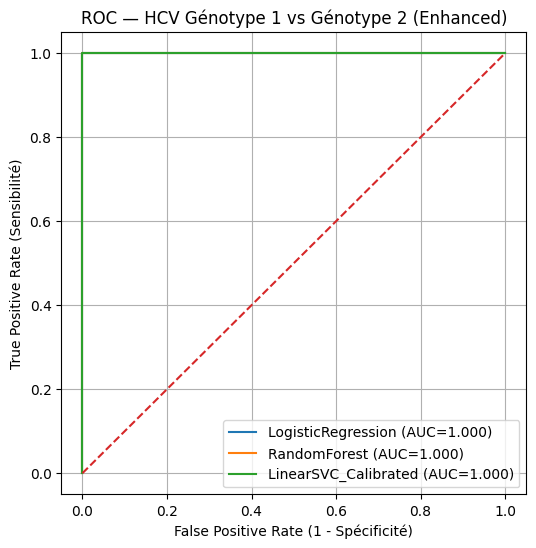

In [10]:
# =========================
# 9) ROC curves
# =========================
plt.figure(figsize=(6,6))
for r in results:
    fpr, tpr, _ = roc_curve(y, r["proba"])
    plt.plot(fpr, tpr, label=f"{r['model']} (AUC={r['auc']:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate (1 - Spécificité)")
plt.ylabel("True Positive Rate (Sensibilité)")
plt.title("ROC — HCV Génotype 1 vs Génotype 2 (Enhanced)")
plt.legend()
plt.grid(True)
plt.show()

## 10) Matrices de confusion + rapports

LogisticRegression
              precision    recall  f1-score   support

      HCV_G1       0.96      1.00      0.98        70
      HCV_G2       1.00      0.96      0.98        70

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



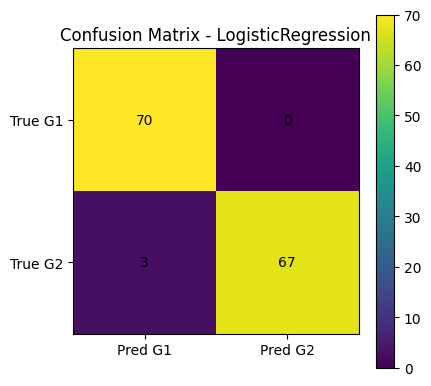

RandomForest
              precision    recall  f1-score   support

      HCV_G1       1.00      1.00      1.00        70
      HCV_G2       1.00      1.00      1.00        70

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



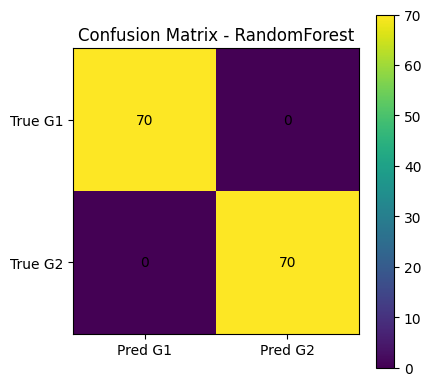

LinearSVC_Calibrated
              precision    recall  f1-score   support

      HCV_G1       1.00      1.00      1.00        70
      HCV_G2       1.00      1.00      1.00        70

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



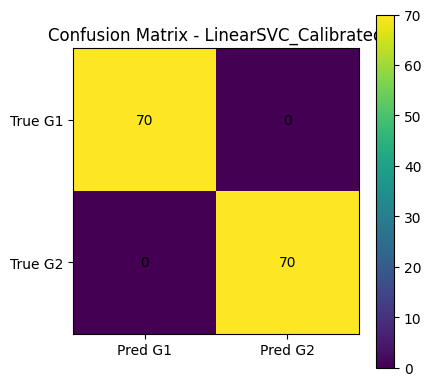

In [11]:
# =========================
# 10) Confusion + reports
# =========================
def plot_cm(cm, title):
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0,1], ["Pred G1", "Pred G2"])
    plt.yticks([0,1], ["True G1", "True G2"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

for r in results:
    print(r["model"])
    print(r["report"])
    plot_cm(r["cm"], f"Confusion Matrix - {r['model']}")

## 11) Tableau comparatif (trié par AUC)

In [12]:
# =========================
# 11) Summary table
# =========================
summary = pd.DataFrame([
    {"Model": r["model"], "Accuracy": r["accuracy"], "Precision": r["precision"], "Recall": r["recall"], "F1": r["f1"], "AUC": r["auc"]}
    for r in results
]).sort_values(by="AUC", ascending=False).reset_index(drop=True)

summary

,Model,Accuracy,Precision,Recall,F1,AUC
0,LogisticRegression,0.978571,1.0,0.957143,0.978102,1.0
1,RandomForest,1.000000,1.0,1.000000,1.000000,1.0
2,LinearSVC_Calibrated,1.000000,1.0,1.000000,1.000000,1.0


## 12) Sauvegarde + téléchargement des artefacts (Colab)
- modèle final (réentraîné sur toutes les données)
- CSV des performances

In [13]:
# =========================
# 12) Save + Download artefacts
# =========================
from google.colab import files

best = summary.iloc[0]["Model"]
best_result = next(r for r in results if r["model"] == best)

best_estimator = best_result["estimator"]
best_estimator.fit(X, y)

joblib.dump(best_estimator, "best_model.joblib")
summary.to_csv("model_comparison.csv", index=False)

print("Saved locally:")
print("- best_model.joblib")
print("- model_comparison.csv")
print("Best model:", best)

files.download("best_model.joblib")
files.download("model_comparison.csv")

Saved locally:
- best_model.joblib
- model_comparison.csv
Best model: LogisticRegression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 13) Discussion (à copier dans le rapport)
- L’usage d’une **fenêtre de longueur fixe** réduit le risque de classification basée sur la complétude.
- La suppression des **doublons exacts** et des **quasi-doublons** limite la redondance et rend la validation plus réaliste.
- Le **sanity check** (labels shuffled) permet de détecter les fuites restantes.
- Une validation externe (autre cohorte / autre source) renforcerait encore la crédibilité.

**Attendu réaliste :** AUC < 1.0, souvent 0.85–0.98 selon la diversité des séquences.